***This notebook is dedicated to evaluated the kidney.csv dataset on the following classification models: logistic regression, k-nearest neighbor and random forest***

# Imports

In [1]:
# DATA MANIPULATION
import pandas as pd
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')



In [2]:
# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScale
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.feature_selection import SelectPercentile, mutual_info_regression
#from sklearn.feature_selection import SequentialFeatureSelector

from data import get_cleaned_data
from randomforest import RandomForest 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA



# Dataset loading

In [3]:
def get_data(url):
    df = pd.read_csv(url)
    return df

kidneys = get_data("../raw_data/kidney_disease.csv")
kidneys.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44.0,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38.0,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31.0,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32.0,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35.0,7300,4.6,no,no,no,good,no,no,ckd


# Dataset preprocess

## cleaning

In [4]:
def replacing_numerical_features(X):
    '''cleaning: strips \t at beginning of number and replaces ? with nan values'''
    X['pcv'] = X['pcv'].astype(str).str.lstrip("\t")
    X['pcv'] = X['pcv'].replace('?',np.nan).astype(float)
    X['wc'] = X['wc'].astype(str).str.lstrip("\t")
    X['wc'] = X['wc'].replace('?',np.nan).astype(float)
    X['rc'] = X['rc'].astype(str).str.lstrip("\t")
    X['rc'] = X['rc'].replace('?',np.nan).astype(float)
    return X

In [5]:
def preprocessing_1(df):
    # convert wc and rc columns to float
    df[['wc', 'rc']] = df[['wc','rc']].apply(pd.to_numeric, errors='coerce')
    df = replacing_numerical_features(df)
    return df


In [6]:
kidneys = preprocessing_1(kidneys)
kidneys.head(4)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd


In [7]:
#def replacing_binary_features(X):
 #   '''encoding: replacing Yes --> 1 no --> 0'''
kidneys[['classification']] = kidneys[['classification']].replace(to_replace={'ckd':1,'notckd':0, 'ckd\t': 1})
kidneys[['htn','dm','cad','pe','ane']] = kidneys[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
kidneys[['pe']] = kidneys[['pe']].replace(to_replace={'good':1})
kidneys[['htn']] = kidneys[['htn']].replace(to_replace={'4':4, '8':8, '?':np.nan, '5.2':5.2})
kidneys[['rbc','pc']] = kidneys[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
kidneys[['pcc','ba']] = kidneys[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
kidneys[['appet']] = kidneys[['appet']].replace(to_replace={'good':2,'poor':1,'no':0})
    ## replacing t_values to 0 or 1, by assuming it s close to 0 or 1, respectively
kidneys[['cad']] = kidneys[['cad']].replace(to_replace='\tno',value=0)
kidneys[['dm']] = kidneys[['dm']].replace(to_replace={'\tno':0,'\tyes':1,' yes':1})
   # return X

In [8]:
def split_num_cat(df):
    # splitting numerical  and categorical features
    feat_num = list(df.nunique()[df.nunique() > 7].index)
    feat_cat = list(df.nunique()[df.nunique() <=7].index)
    feat_cat_bin = list(df[feat_cat].nunique()[df[feat_cat].nunique() ==2].index)
    feat_cat_ord = list(set(df.columns) - set(feat_num) - set(feat_cat_bin))

    #feat_num = df.select_dtypes(include=['float64', 'int64'])
    #feat_cat = df.drop(columns = feat_num.columns)
    # cleaning categorical features 
    
    #df_new = pd.concat([feat_cat, feat_num], axis = 1)
    return (feat_num, feat_cat_bin, feat_cat_ord)


In [9]:

feat_num = split_num_cat(kidneys)[0]
feat_cat_bin = split_num_cat(kidneys)[1]
feat_cat_ord = split_num_cat(kidneys)[2]

kidneys[feat_num]

,id,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
0,0,48.0,80.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2
1,1,7.0,50.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN
2,2,62.0,80.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN
3,3,48.0,70.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9
4,4,51.0,80.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9
396,396,42.0,70.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2
397,397,12.0,80.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4
398,398,17.0,60.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9


In [10]:
def feat_target(a,b,c):
    df_new = pd.concat([pd.concat([a, b], axis =1),c], axis=1)
    return df_new

In [11]:
kidneys_new = feat_target(kidneys[feat_num], kidneys[feat_cat_bin],kidneys[feat_cat_ord])
kidneys_new.head(4)

,id,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,...,dm,cad,pe,ane,classification,sg,htn,su,al,appet
0,0,48.0,80.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,...,1.0,0.0,0.0,0.0,1,1.020,1.0,0.0,1.0,2.0
1,1,7.0,50.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,...,0.0,0.0,0.0,0.0,1,1.020,0.0,0.0,4.0,2.0
2,2,62.0,80.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,...,1.0,0.0,0.0,1.0,1,1.010,0.0,3.0,2.0,1.0
3,3,48.0,70.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,...,0.0,0.0,1.0,1.0,1,1.005,1.0,0.0,4.0,1.0


##  imputing and scaling (pipeline) 

In [12]:
def feat_target_split(df):
    # defining X and y
    X = df.drop(columns=['classification','id'])
    y = df['classification']
    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size = 0.2)
    return (X,y, X_train, X_test, y_train, y_test)

In [13]:
X = feat_target_split(kidneys_new)[0]
y = feat_target_split(kidneys_new)[1]
X_train = feat_target_split(kidneys_new)[2]
X_test = feat_target_split(kidneys_new)[3]
y_train = feat_target_split(kidneys_new)[4]
y_test = feat_target_split(kidneys_new)[5]
X_train.head()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wc,...,ba,dm,cad,pe,ane,sg,htn,su,al,appet
200,90.0,90.0,139.0,89.0,3.0,140.0,4.1,12.0,37.0,7900.0,...,0.0,1.0,0.0,0.0,0.0,1.025,1.0,0.0,1.0,2.0
194,80.0,70.0,NaN,49.0,1.2,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,1.0,1.0,0.0,1.010,1.0,NaN,2.0,0.0
282,20.0,70.0,123.0,44.0,1.0,135.0,3.8,14.6,44.0,5500.0,...,0.0,0.0,0.0,0.0,0.0,1.020,0.0,0.0,0.0,2.0
130,50.0,90.0,128.0,208.0,9.2,134.0,4.8,8.2,22.0,16300.0,...,1.0,0.0,0.0,1.0,1.0,1.010,0.0,0.0,2.0,1.0
199,65.0,80.0,92.0,37.0,1.5,140.0,5.2,8.8,25.0,10700.0,...,0.0,0.0,1.0,1.0,0.0,1.015,1.0,0.0,0.0,2.0


In [14]:
def preprocessing_2(a,b,X):
    #remove y from the categorical features
    feat_cat_bin = b.drop(columns = 'classification')
    #remove id from the numerical features
    feat_num = a.drop(columns = 'id')
    return (list(feat_num.columns), list(feat_cat_bin.columns))

In [15]:

a = preprocessing_2(kidneys[feat_num], kidneys[feat_cat_bin], X)[0]
b = preprocessing_2(kidneys[feat_num], kidneys[feat_cat_bin], X)[1]
c = feat_cat_ord = split_num_cat(kidneys)[2]

In [16]:
def pipe(a,b,c):
    
    # imputing and scaling numerical features
    preproc_num = make_pipeline(SimpleImputer(strategy = "most_frequent"), MinMaxScaler())
    
    # imputing categorical features with unique values < 5
    preproc_cat = make_pipeline(SimpleImputer(strategy="most_frequent"))
    # scaling remaining (ordinal)
    preproc_cat_ord = make_pipeline(SimpleImputer(strategy="most_frequent"), MinMaxScaler())

    preproc_baseline = make_column_transformer((preproc_num, a),
    (preproc_cat, b),
    (preproc_cat_ord,c))

    return preproc_baseline

In [17]:
pipe = pipe(a,b,c)
pipe

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot',
                                  'hemo', 'pcv', 'wc', 'rc']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['rbc', 'pc', 'pcc', 'ba', 'dm', 'cad', 'pe',
                                  'ane']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['sg', 'htn', 'su', 'al', 'appet'])])

# Cleaned and scaled X_train and X_test

In [18]:
# final transformed X_train and X_test
SimpleImputer.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)


X_train_transform = pipe.fit_transform(X_train)
pipe.get_feature_names_out()
X_train_final = pd.DataFrame(X_train_transform, columns=pipe.get_feature_names_out())

X_test_transform = pipe.fit_transform(X_test)
pipe.get_feature_names_out()
X_test_final = pd.DataFrame(X_test_transform, columns=pipe.get_feature_names_out())

In [19]:
X_test_final.columns = X.columns
X_train_final.columns = X.columns
X_test_final.head()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wc,...,ba,dm,cad,pe,ane,sg,htn,su,al,appet
0,0.591549,0.428571,0.054762,0.060367,0.012698,0.612245,0.044321,0.653846,1.000000,0.305687,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,1.0
1,0.830986,0.571429,0.054762,0.065617,0.025397,0.428571,0.016620,0.423077,1.000000,0.263953,...,0.0,1.0,0.0,1.0,0.0,0.000000,0.192308,0.6,0.6,1.0
2,0.859155,0.285714,0.897619,0.081365,0.038095,0.346939,0.027701,0.592308,0.500000,0.362598,...,0.0,1.0,0.0,0.0,0.0,0.333333,0.192308,1.0,0.4,1.0
3,0.225352,0.571429,0.088095,0.078740,0.038095,0.224490,0.016620,0.269231,0.236842,0.468832,...,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.8,1.0
4,0.788732,0.285714,0.119048,0.049869,0.006349,0.469388,0.016620,0.969231,1.000000,0.263953,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,1.0


# Add a logistic regression estimator and crossvalidate

## checking if matrix is full rank

In [20]:
np.linalg.matrix_rank(X_train_final)

24

## baseline scores for different models

In [21]:
def baseline_score(model, pipeline, X, y,cv, scoring):
    baseline_pipe = make_pipeline(pipeline, model)
    score = cross_val_score(baseline_pipe, X,y, cv=cv, scoring= scoring).mean()
    return score

In [22]:
baseline_score(RandomForestClassifier(), pipe, X, y,10, 'recall')

1.0

# feature selection

## correlation between features

In [23]:
def heat_map(X):
    f,ax = plt.subplots(figsize=(12, 12))
    return sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

<AxesSubplot:>

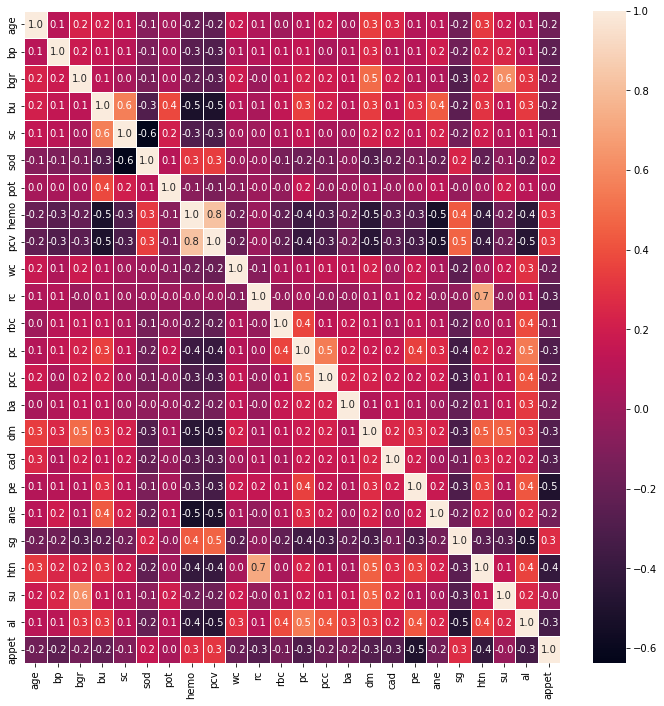

In [24]:
heat_map(X_train_final)

there a strong correlation between 'pcv' and 'hemo' as well between 'rc' and 'htn'. 

## recursive feature elimination(RFE) with cross validation

In [25]:
def rfe(estimator, step, cv, scoring, X, y):
    '''this function select the optimal number of features to be selected given an estimator which not KNeighborsClassifier
       '''
    
    # fitting the estimator/model
    rfecv = RFECV(estimator=estimator, step=step, cv=cv,scoring=scoring).fit(X, y)
    
    n = rfecv.n_features_                                       # optimal number of features
    best_features = X.columns[rfecv.support_]                   # the actual best features
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score of number of selected features")
    plt.plot(range(1, rfecv.cv_results_['mean_test_score'].shape[0] +1) , rfecv.cv_results_['mean_test_score'])
      
    return plt.figure();


    
        
        

<Figure size 432x288 with 0 Axes>

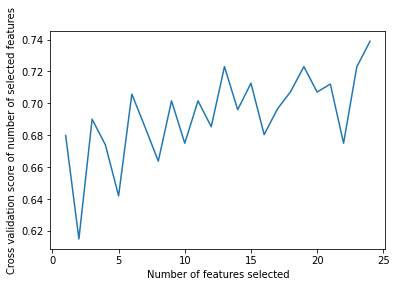

<Figure size 432x288 with 0 Axes>

In [26]:
rfe(RandomForestClassifier(), 1, 5, 'recall', X_train_final,y_train)



In [27]:
def fi_selectbest(X,y,p):
    '''This function plot the p best features'''
    
    # apply SelectKBest class to extract top n best features
    best_RF = SelectKBest(score_func=chi2, k=p).fit(X,y)
    dfscores = pd.DataFrame(best_RF.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)

    feat_importances_SB = pd.Series(best_RF.scores_, index=X.columns)
    plt.xlabel("features")
    plt.ylabel("scores")
    return feat_importances_SB.nlargest(p).plot.bar(x='features', y='scores')

<AxesSubplot:xlabel='features', ylabel='scores'>

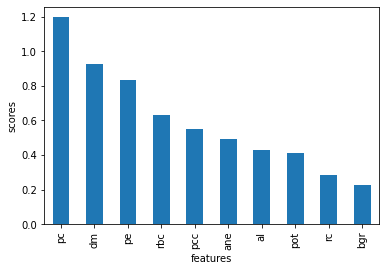

In [28]:
fi_selectbest(X_train_final, y_train, 10)

In [29]:
def fi_rfe(estimator, n_features_to_select, step, X,y):
    ''' this function ranks the features. The feature ranked first (rank = 1) is the more important'''
    
    rfe = RFE(estimator=estimator, n_features_to_select= n_features_to_select, step=step).fit(X, y)
    dfrank = pd.DataFrame(rfe.ranking_)
    dfcolumns = pd.DataFrame(X.columns)
    
    #concat two dataframes for better visualization 
    featurerank = pd.concat([dfcolumns,dfrank],axis=1)

    feat_importances_rfe = pd.DataFrame(rfe.ranking_, index=X.columns)
    feat_importances_rfe.columns =['rank'] 
    feat_importances_rfe = feat_importances_rfe.sort_values(by = ['rank'])
    feat_importances_rfe['rank'].squeeze()                 # get the dataframe back to a series
    #feat_importances_rfe.nsmallest(n_features_to_select, columns ='rank').plot.bar( y= "rank")
    return feat_importances_rfe.plot.bar( y= "rank")

    




<AxesSubplot:>

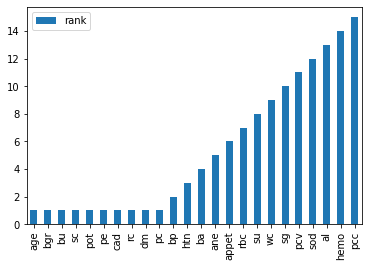

In [30]:
fi_rfe(LogisticRegression(), 10, 1, X_train_final,y_train)

## Confusion matrices

In [31]:

def confusion_score(classifier, X_train,y_train, y_test,X_test):
       
    clr_rf = classifier.fit(X_train,y_train)

    ac = accuracy_score(y_test,classifier.predict(X_test))
    cm = confusion_matrix(y_test,clr_rf.predict(X_test))
    
    return(sns.heatmap(cm,annot=True,fmt="d"), f'Accuracy is {ac}')



(<AxesSubplot:>, 'Accuracy is 0.55')

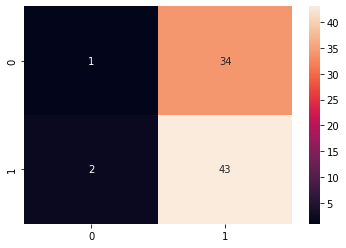

In [32]:
confusion_score(LogisticRegression(), X_train_final,y_train,y_test,X_test_final)

## Tree based feature selection and random forest classification

Feature ranking:
1. feature 2 (0.098898)
2. feature 0 (0.095801)
3. feature 3 (0.095428)
4. feature 7 (0.088473)
5. feature 4 (0.077890)
6. feature 9 (0.074300)
7. feature 5 (0.074132)
8. feature 6 (0.071737)
9. feature 8 (0.061927)
10. feature 10 (0.059814)
11. feature 1 (0.041039)
12. feature 19 (0.029982)
13. feature 22 (0.026611)
14. feature 21 (0.014967)
15. feature 12 (0.014017)
16. feature 23 (0.012675)
17. feature 20 (0.010535)
18. feature 15 (0.009992)
19. feature 11 (0.009558)
20. feature 18 (0.009123)
21. feature 17 (0.008454)
22. feature 13 (0.005515)
23. feature 16 (0.005450)
24. feature 14 (0.003681)


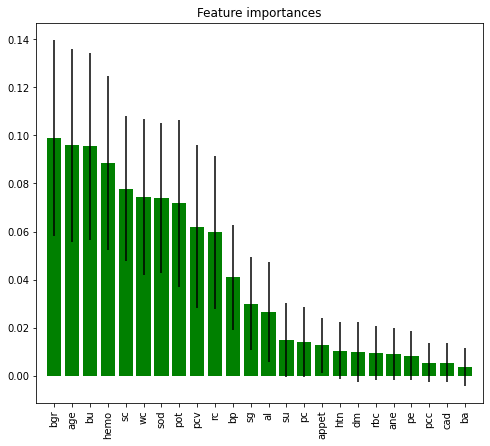

In [33]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train_final,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(8, 7))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Feature Extraction with PCA

In [34]:
def fe_pca(model, X):
    ''' this function defines the best number of features to select based on the explained variance ratio from PCA'''
    pca = model.fit(X)
    plt.axes([.2, .2, .7, .7])
    
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_ratio_')
    return plt.plot(pca.explained_variance_ratio_, linewidth=2)

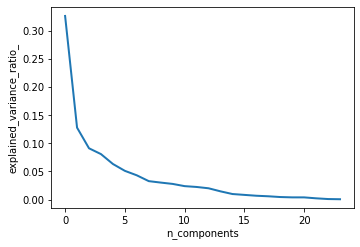

In [35]:
fe_pca(PCA(),X_train_final)